In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import constants as const
import astropy.units as u

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, RBF

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928
mu = 33.14
dist = 42.5

# Bolometric Luminosity

We will estimate the bolometric luminosity by integrating the SED (using trapezoidal integration). The optical observations will be interpolated to the times of UV observations, which are far less frequent.

In [16]:
flux_obs = pd.read_csv('../plots/flux_obs_19yvq.csv')
flux_obs.head(5)

,t_restframe,flux_Jy,flux_unc_Jy,filt
0,0.779844,0.000505,0.000007,r
1,0.847793,0.000374,0.000005,i
2,0.867332,0.000595,0.000006,g
3,3.731084,0.000488,0.000008,r
4,3.789436,0.000379,0.000006,g


In [17]:
swift_obs = np.where((flux_obs.filt == 'UVW1') | 
                     (flux_obs.filt == 'UVM2') | 
                     (flux_obs.filt == 'UVW2') )

In [56]:
this_epoch = flux_obs.t_restframe.values[438]
this_uvm2 = flux_obs.flux_Jy.iloc[np.where(flux_obs.t_restframe == this_epoch)].values[0]
this_uvw1 = flux_obs.flux_Jy.iloc[np.where((np.abs(flux_obs.t_restframe - this_epoch) < 0.04) & 
                                           (flux_obs.filt == 'UVW1'))].values[0]


In [57]:
uvm2_lambda_eff = 2360
uvw1_lambda_eff = 3050
g_lambda_eff = 4722.74
r_lambda_eff = 6339.61
i_lambda_eff = 7886.13

In [527]:
nu_eff = const.c.to('Angstrom/s').value/np.array([1000,
                                                  uvm2_lambda_eff, 
                                                  uvw1_lambda_eff, 
                                                  g_lambda_eff, 
                                                  r_lambda_eff, 
                                                  i_lambda_eff, 
                                                  21590])

In [505]:
g_obs = np.where(flux_obs.filt == 'g')
r_obs = np.where(flux_obs.filt == 'r')
i_obs = np.where(flux_obs.filt == 'i')

uvw1_obs = np.where(flux_obs.filt == 'UVW1')
uvm2_obs = np.where(flux_obs.filt == 'UVM2')

X_uvm2 = np.atleast_2d(flux_obs.iloc[uvm2_obs].t_restframe).T
y_uvm2 = flux_obs.iloc[uvm2_obs].flux_Jy


X_uvw1 = np.atleast_2d(flux_obs.iloc[uvw1_obs].t_restframe).T
y_uvw1 = flux_obs.iloc[uvw1_obs].flux_Jy

X_g = np.atleast_2d(flux_obs.iloc[g_obs].t_restframe).T
y_g = flux_obs.iloc[g_obs].flux_Jy

X_r = np.atleast_2d(flux_obs.iloc[r_obs].t_restframe).T
y_r = flux_obs.iloc[r_obs].flux_Jy

X_i = np.atleast_2d(flux_obs.iloc[i_obs].t_restframe).T
y_i = flux_obs.iloc[i_obs].flux_Jy


kernel = ConstantKernel(1)*Matern(length_scale=25, length_scale_bounds=(1e-2,100)) 

gpr_uvm2 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvm2_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvm2, y_uvm2)

gpr_uvw1 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvw1_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvw1, y_uvw1)


gpr_g = GaussianProcessRegressor(kernel=kernel, 
                                 alpha=flux_obs.iloc[g_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_g, y_g)

gpr_r = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[r_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_r, y_r)


gpr_i = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[i_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_i, y_i)


In [639]:
# K band to i band relative flux at 8500 K
temp = u.Kelvin*8500

i_bb = 1/(u.Angstrom*7886.13)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*7886.13))) - 1))
J_bb = 1/(u.Angstrom*12350)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*12350))) - 1))
H_bb = 1/(u.Angstrom*16620)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*16620))) - 1))
K_bb = 1/(u.Angstrom*21590)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*21590))) - 1))
bb_10 = 1/(u.Angstrom*100000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*100000))) - 1))

print(K_bb/i_bb)

full_curve = 1/(u.Angstrom*np.linspace(1e7,1e3,10000))**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*np.linspace(1e7,1e3,10000)))) - 1))

temp = u.Kelvin*12500
uvm2_bb = 1/(u.Angstrom*2360)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*2360))) - 1))
bb_1000 = 1/(u.Angstrom*1000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*1000))) - 1))

print(bb_1000/uvm2_bb)

0.30929811261165874
0.017168826141433047


<IPython.core.display.Javascript object>


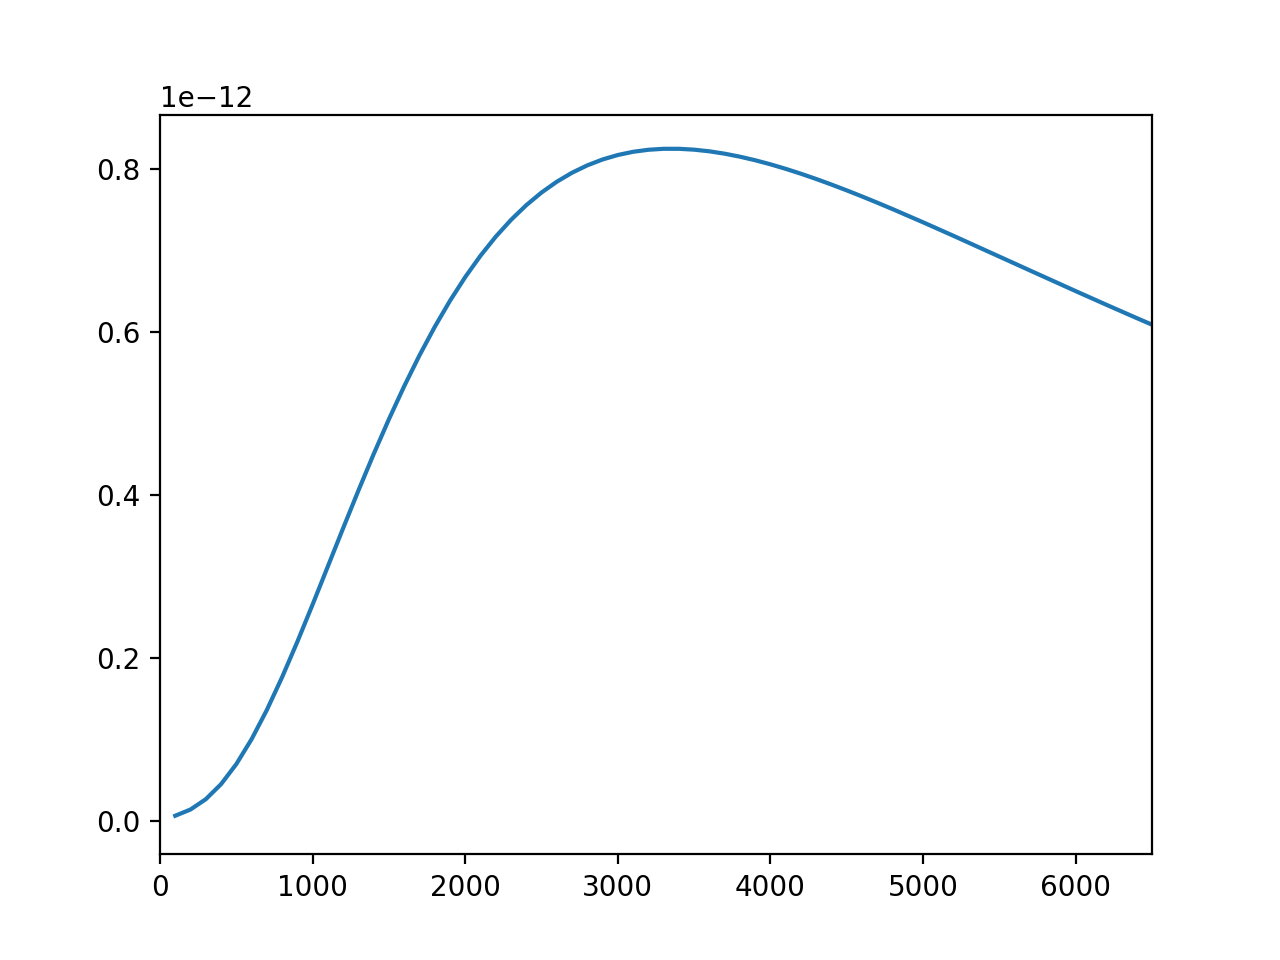

(0, 6500)

In [550]:
full_curve = 1/(u.Angstrom*np.linspace(1e7,1e3,100000))**3*(1/(np.exp(const.h*const.c/(const.k_B*u.Kelvin*12000*(u.Angstrom*np.linspace(1e7,1e3,100000)))) - 1))
plt.figure()
plt.plot(np.linspace(1e7,1e2,100000), full_curve)
plt.xlim(0,6500)

In [545]:
t_grid = np.linspace(0,45,451)

obs_sed = np.array([gpr_uvm2.predict(np.atleast_2d(t_grid).T)*bb_1000/uvm2_bb,
                    gpr_uvm2.predict(np.atleast_2d(t_grid).T),
                    gpr_uvw1.predict(np.atleast_2d(t_grid).T),
                    gpr_g.predict(np.atleast_2d(t_grid).T), 
                    gpr_r.predict(np.atleast_2d(t_grid).T), 
                    gpr_i.predict(np.atleast_2d(t_grid).T),
                    gpr_i.predict(np.atleast_2d(t_grid).T)*K_bb/i_bb])

red_correction = 10**(0.4*np.array([0.4043,0.4043, 0.2745, 0.1877, 0.1240, 0.0876, 
                                    0.0876]))
true_sed = obs_sed.T*red_correction

In [546]:
flux2lum = 1e-23*4*np.pi*(42.5e6*const.pc.to('cm').value)**2

lum = np.trapz(np.flip(true_sed, axis=1), nu_eff[::-1]*(1+z)) * flux2lum

<IPython.core.display.Javascript object>


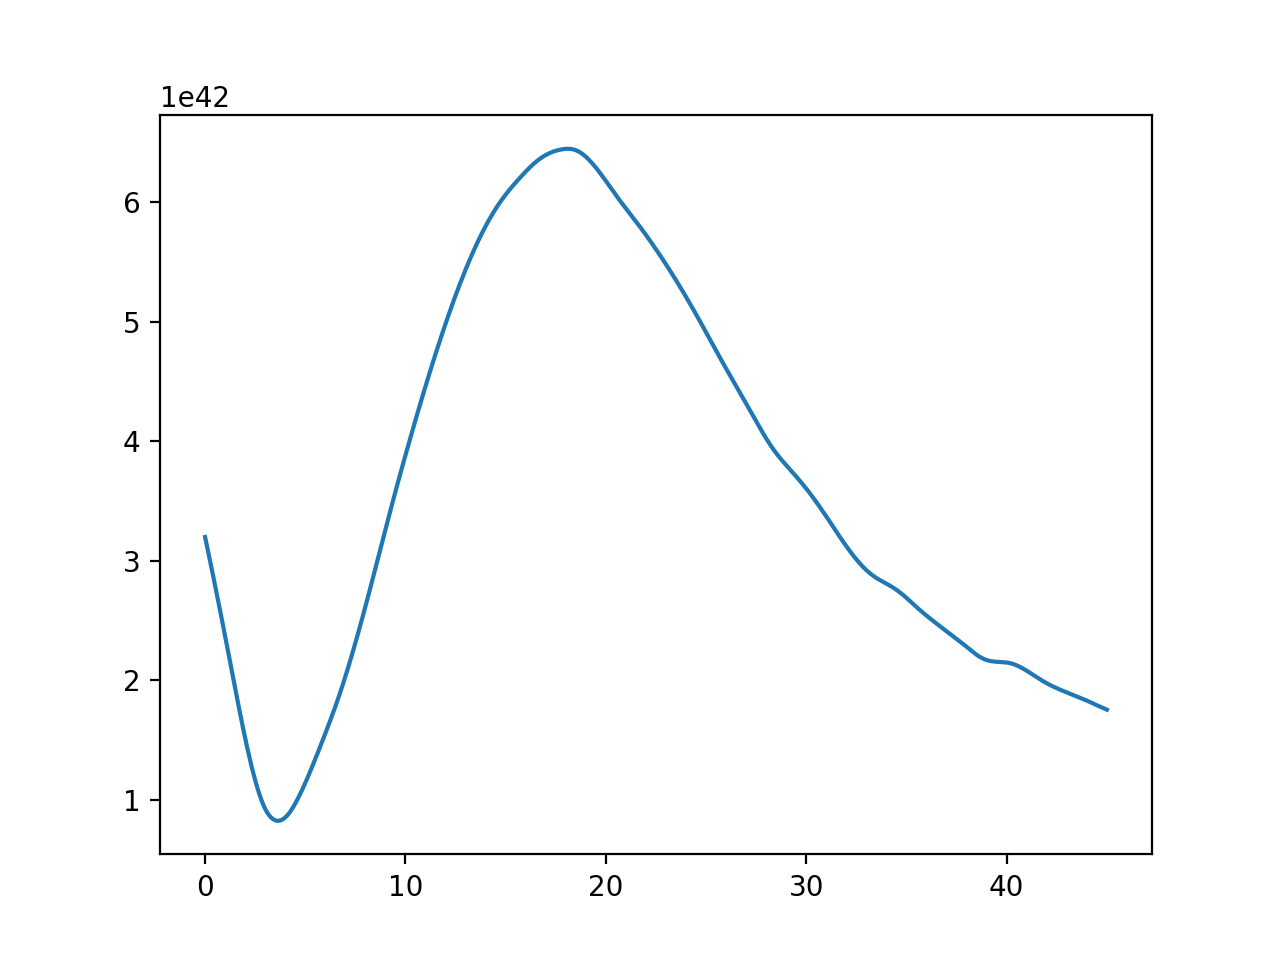

In [554]:
plt.figure()
plt.plot(t_grid, lum)

In [551]:
uvm2_pred, uvm2_unc = gpr_uvm2.predict(np.atleast_2d(t_grid).T, return_std=True)
uvw1_pred, uvw1_unc = gpr_uvw1.predict(np.atleast_2d(t_grid).T, return_std=True)
g_pred, g_unc = gpr_g.predict(np.atleast_2d(t_grid).T, return_std=True) 
r_pred, r_unc = gpr_r.predict(np.atleast_2d(t_grid).T, return_std=True) 
i_pred, i_unc = gpr_i.predict(np.atleast_2d(t_grid).T, return_std=True)

In [592]:
uvm2_pred[0], uvm2_unc[0]

(0.0005647927013274767, 5.856410953232379e-05)

In [596]:
np.random.normal(5.6e-4, 5.85e-5, size=100)

array([0.00060342, 0.00059355, 0.00050486, 0.00056278, 0.00055228,
       0.00046036, 0.00056759, 0.00049926, 0.00056798, 0.00055724,
       0.00056945, 0.00055032, 0.00056719, 0.00060669, 0.00049285,
       0.00066864, 0.00059646, 0.00055864, 0.00046597, 0.0006089 ,
       0.00049447, 0.00062219, 0.00066165, 0.00059845, 0.00047943,
       0.00051185, 0.00049344, 0.00054783, 0.00051434, 0.00059476,
       0.00054328, 0.00048976, 0.00061132, 0.00059534, 0.00056819,
       0.00052509, 0.00060634, 0.00050243, 0.00047463, 0.00048822,
       0.00051209, 0.00054671, 0.00054446, 0.00068336, 0.0006047 ,
       0.00054299, 0.0006256 , 0.00052877, 0.00057179, 0.00054722,
       0.00044453, 0.0006877 , 0.00056035, 0.00062756, 0.00050349,
       0.0005939 , 0.00057199, 0.00059942, 0.00055421, 0.00057697,
       0.00047775, 0.00064587, 0.000529  , 0.00059625, 0.00059919,
       0.00049348, 0.00063304, 0.00059646, 0.00051667, 0.00062299,
       0.00058059, 0.0005252 , 0.00055229, 0.00050851, 0.00059

In [614]:
lum_unc = np.zeros((len(lum), 2))
for idx in range(len(lum)):
    uvm2_rand = np.random.normal(uvm2_pred[idx], uvm2_unc[idx], size=1000)
    uvw1_rand = np.random.normal(uvw1_pred[idx], uvw1_unc[idx], size=1000)
    g_rand = np.random.normal(g_pred[idx], g_unc[idx], size=1000)
    r_rand = np.random.normal(r_pred[idx], r_unc[idx], size=1000)
    i_rand = np.random.normal(i_pred[idx], i_unc[idx], size=1000)
    
    uvm2_rand = np.clip(uvm2_rand, 0, 1e10)
    uvw1_rand = np.clip(uvw1_rand, 0, 1e10)
    
    rand_sed = np.vstack([uvm2_rand*bb_1000.value/uvm2_bb.value, 
                      uvm2_rand, uvw1_rand, g_rand, r_rand, i_rand, 
                      i_rand*K_bb.value/i_bb.value]).T
    
    lum_unc[idx] = np.percentile(np.trapz(np.flip(rand_sed*red_correction, axis=1), 
                                          nu_eff[::-1]*(1+z)) * flux2lum, (16,84))

In [633]:
yunc = np.abs((lum_unc - lum[:,np.newaxis]).T)

In [629]:
yunc[:,0]

array([-1.78513231e+41,  2.29974498e+41])

In [631]:
lum[0]

3.197805686836717e+42

In [632]:
lum_unc[0]

array([3.01929246e+42, 3.42778019e+42])

<IPython.core.display.Javascript object>


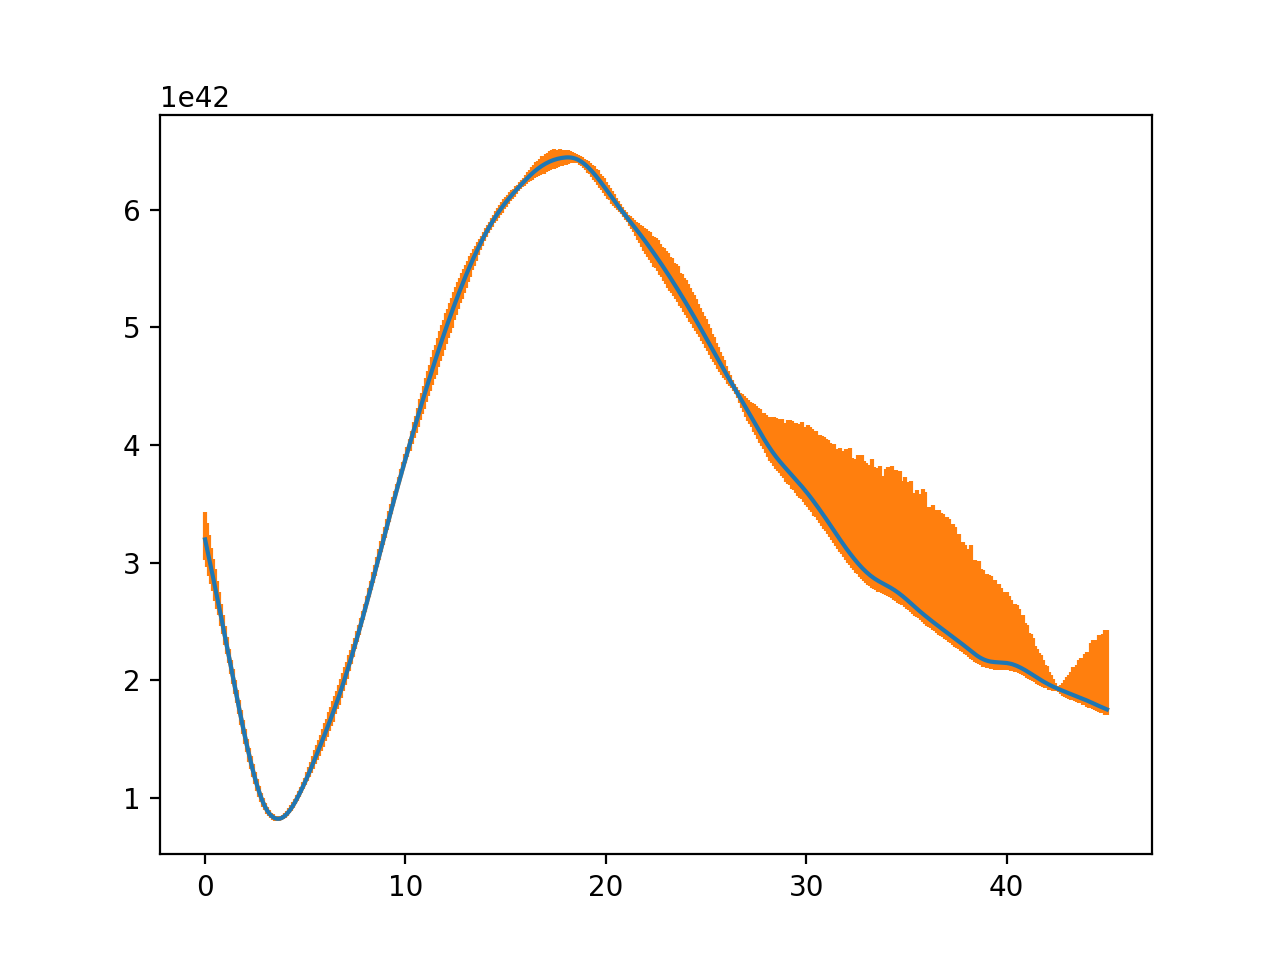

<ErrorbarContainer object of 3 artists>

In [637]:
plt.figure()
plt.plot(t_grid, lum, zorder=10)
plt.errorbar(t_grid, lum, yerr=yunc)

In [624]:
plt.errorbar?

In [494]:
kernel = ConstantKernel(1)*Matern(length_scale=25, length_scale_bounds=(1e-2,100)) #+ WhiteKernel(1e-9, (1e-12,1))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=flux_obs.iloc[this_filt].flux_unc_Jy.values**2, 
                               n_restarts_optimizer=9).fit(X, y)

In [495]:
gpr.predict([[12]], return_std=True)

(array([0.00023948]), array([4.53099977e-05]))

<IPython.core.display.Javascript object>


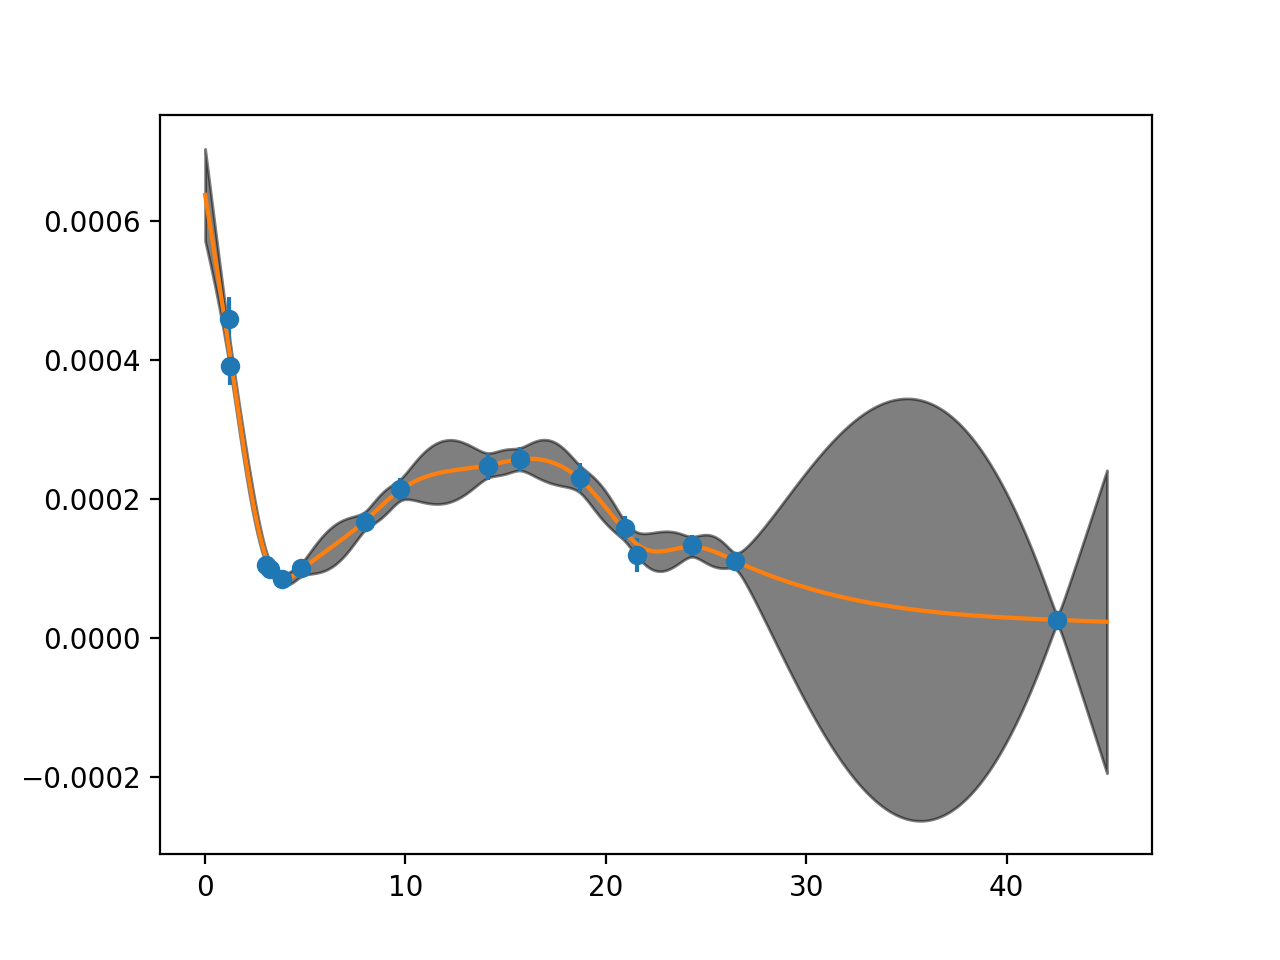

In [496]:
plt.figure()
plt.errorbar(flux_obs.iloc[this_filt].t_restframe, 
             flux_obs.iloc[this_filt].flux_Jy, 
             flux_obs.iloc[this_filt].flux_unc_Jy, 
             fmt='o')
y_pred, y_std = gpr.predict(x, return_std=True)
plt.plot(x, y_pred)
plt.fill_between(x[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')

In [497]:
gpr.kernel_

0.00316**2 * Matern(length_scale=44.3, nu=1.5)

In [271]:
flux_obs.iloc[g_obs]

,t_restframe,flux_Jy,flux_unc_Jy,filt
2,0.867332,0.000595,0.000006,g
4,3.789436,0.000379,0.000006,g
5,3.791270,0.000379,0.000006,g
8,4.805819,0.000507,0.000008,g
9,4.806759,0.000495,0.000005,g
12,5.772026,0.000759,0.000009,g
13,6.760994,0.001026,0.000012,g
15,7.755419,0.001420,0.000018,g
22,9.654031,0.002211,0.000026,g
23,9.671930,0.002256,0.000016,g


In [209]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)


# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)
print(gp.get_params())
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)
print(gp.get_params())
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)


{'alpha': array([0.41009543, 0.48734569, 1.69193643, 2.15579205, 0.66165889,
       1.42163322, 1.8944471 , 1.94492775, 0.34227673, 0.29058006,
       0.44867279, 1.89927676, 0.35801893, 0.84843926, 2.12544188,
       1.06743051, 1.42057105, 0.66506574, 1.40778445, 1.78122568]), 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=10), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 10, 'kernel__k2__length_scale_bounds': (0.01, 100.0), 'kernel': 1**2 * RBF(length_scale=10), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
{'alpha': array([0.41009543, 0.48734569, 1.69193643, 2.15579205, 0.66165889,
       1.42163322, 1.8944471 , 1.94492775, 0.34227673, 0.29058006,
       0.44867279, 1.89927676, 0.35801893, 0.84843926, 2.12544188,
       1.06743051, 1.42057105, 0.66506574, 1.40778445, 1.78122568]), 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel_